In [3]:
import numpy as np

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
matplotlib.rcParams.update({'font.size': 22})
rc('text', usetex=True)

In [5]:
from pyke.prf import PRFPhotometry

/Users/jvmirca/dev/PyKE/pyke/__init__.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jvmirca/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jvmirca/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.insta

In [6]:
from pyke.prf import SimpleKeplerPRF

In [7]:
from pyke.targetpixelfile import KeplerTargetPixelFile

In [8]:
from pyke.utils import KeplerQualityFlags

In [11]:
tpf = KeplerTargetPixelFile('kplr010053146-2013011073258_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.HARDEST_BITMASK)

(<matplotlib.figure.Figure at 0x1c12defb70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c156e7908>)

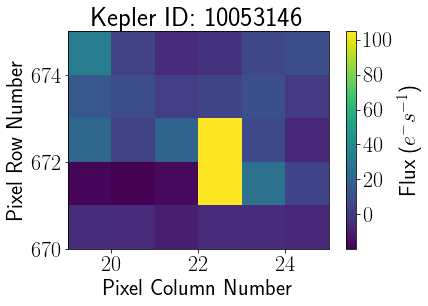

In [12]:
tpf.plot(frame=1)

In [13]:
lc = tpf.to_lightcurve()

In [14]:
aper_flux = lc.flux

Text(0.5,0,'Time (days)')

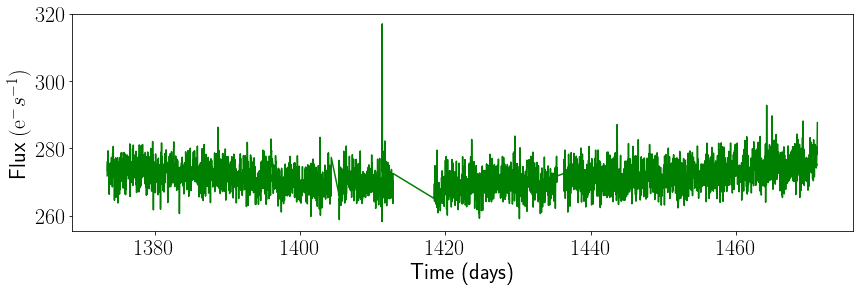

In [15]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, lc.flux, color='green')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

In [16]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [17]:
from oktopus.prior import UniformPrior

In [18]:
prior = UniformPrior(lb=[100, 21, 670, 10],
                     ub=[1e4, 24, 674, 300])

In [19]:
from pyke.prf import SceneModel

In [20]:
scene = SceneModel(prfs=[prf])

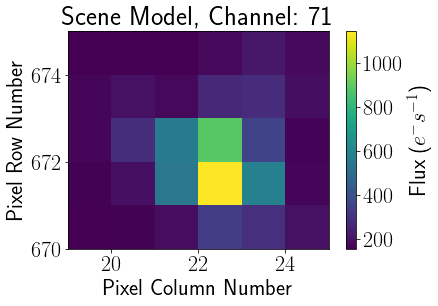

In [21]:
scene.plot(*prior.mean)

In [22]:
phot_poisson = PRFPhotometry(scene_model=scene, prior=prior)

In [23]:
results = phot_poisson.fit(tpf_flux=(tpf.flux + tpf.flux_bkg), options={'ftol':1e-9})

  0%|          | 0/4118 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 4118/4118 [03:18<00:00, 20.73it/s]


In [24]:
flux = results[:, 0]
xcenter = results[:, 1]
ycenter = results[:, 2]
bkg = results[:, 3]

Text(0.5,0,'Time (days)')

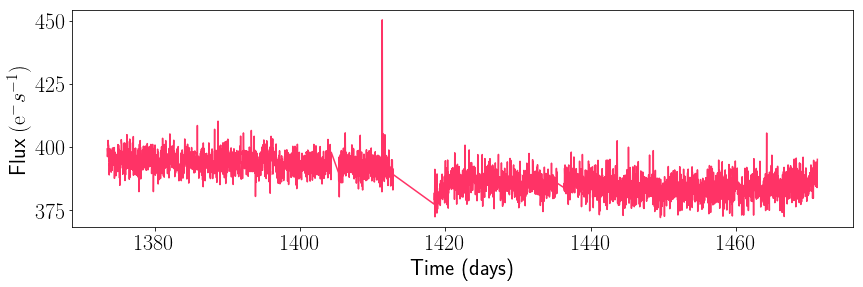

In [25]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, flux, color='#ff3366')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

Text(0.5,0,'Time (days)')

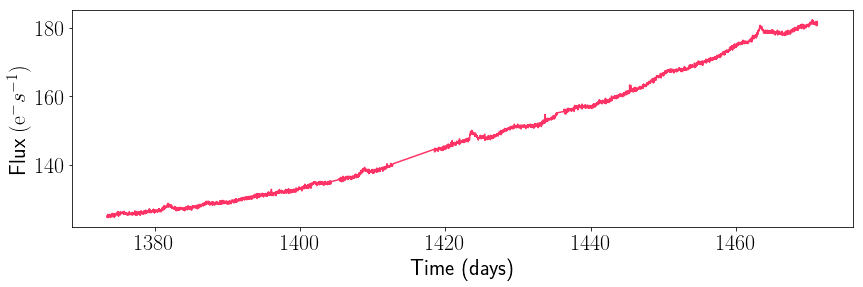

In [26]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, bkg, color='#ff3366')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

Text(0.5,0,'Time (days)')

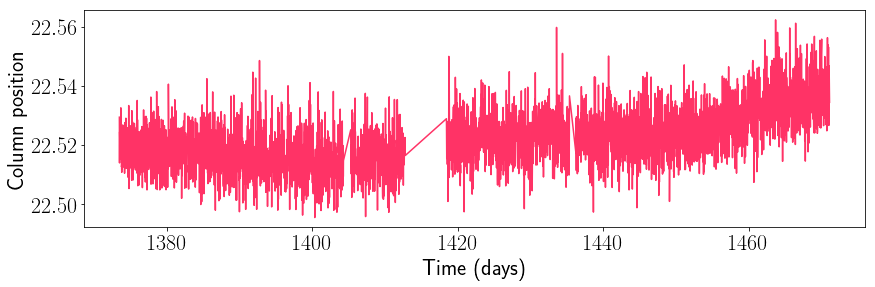

In [27]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, xcenter, color='#ff3366')
plt.ylabel('Column position')
plt.xlabel('Time (days)')

Text(0.5,0,'Time (days)')

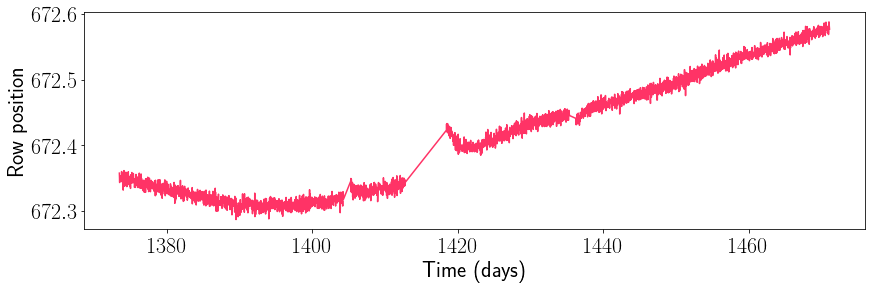

In [28]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, ycenter, color='#ff3366')
plt.ylabel('Row position')
plt.xlabel('Time (days)')

In [29]:
residuals_poisson = phot_poisson.residuals

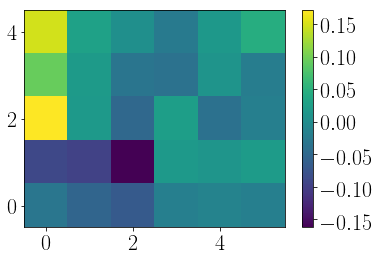

In [31]:
plt.imshow(residuals_poisson[-1]/(tpf.flux[-1] + tpf.flux_bkg[-1]), origin='lower')
plt.colorbar()

Text(0.5,0,'Time (days)')

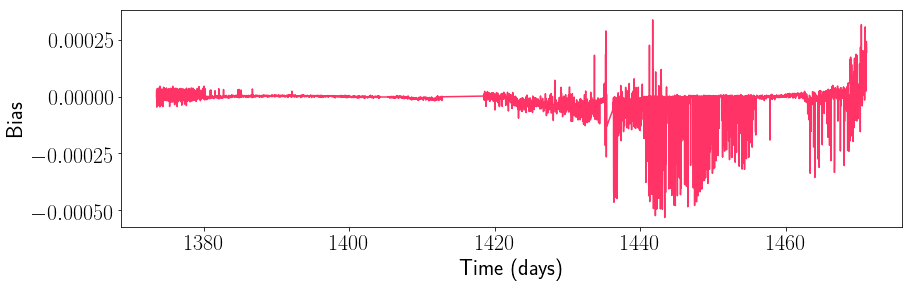

In [32]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, np.nanmean(residuals_poisson, axis=(1,2)), color='#ff3366')
plt.ylabel('Bias')
plt.xlabel('Time (days)')

In [33]:
from oktopus import GaussianPosterior
import tqdm

In [34]:
opt_params = np.array([])
residuals_gaussian = np.array([])
uncertainties = np.array([])
for i in tqdm.tqdm(range(0, tpf.flux.shape[0])):
    loss = GaussianPosterior(data=(tpf.flux[i] + tpf.flux_bkg[i]), mean=scene,
                             var=(tpf.flux[i] + tpf.flux_bkg[i]), prior=prior)
    result = loss.fit(x0=prior.mean, method='powell')
    opt_params = np.append(opt_params, result.x)
    residuals_gaussian = np.append(residuals_gaussian, tpf.flux[i] + tpf.flux_bkg[i] - scene(*result.x))
    #uncertainties = np.append(uncertainties, loss.loglikelihood.uncertainties(result.x))
opt_params = opt_params.reshape((tpf.flux.shape[0], 4))
residuals_gaussian = residuals_gaussian.reshape(tpf.flux.shape)

  0%|          | 0/4118 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 4118/4118 [02:06<00:00, 32.62it/s]


In [35]:
flux_gauss = opt_params[:, 0]
xcenter_gauss = opt_params[:, 1]
ycenter_gauss = opt_params[:, 2]
bkg_gauss = opt_params[:, 3]

Text(0.5,0,'Time (days)')

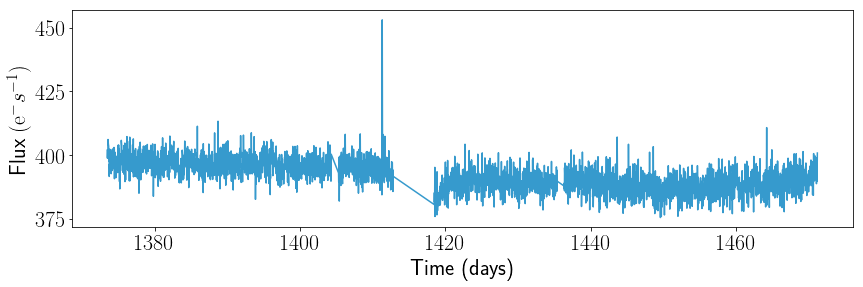

In [36]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, flux_gauss, color='#369acd')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

Text(0.5,0,'Time (days)')

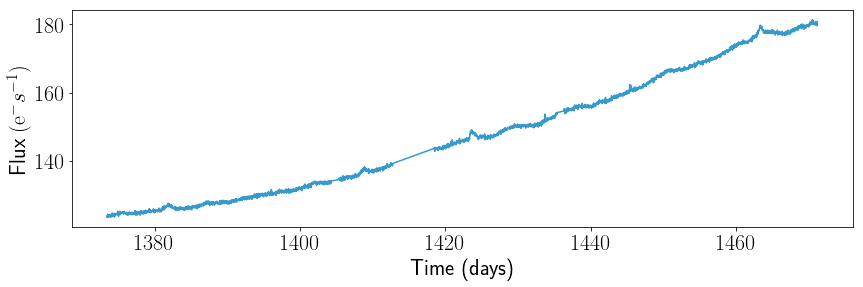

In [37]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, bkg_gauss, color='#369acd')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

Text(0.5,0,'Time (days)')

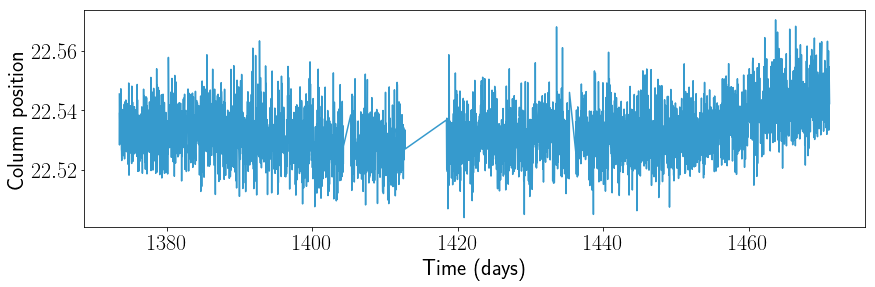

In [38]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, xcenter_gauss, color='#369acd')
plt.ylabel('Column position')
plt.xlabel('Time (days)')

Text(0.5,0,'Time (days)')

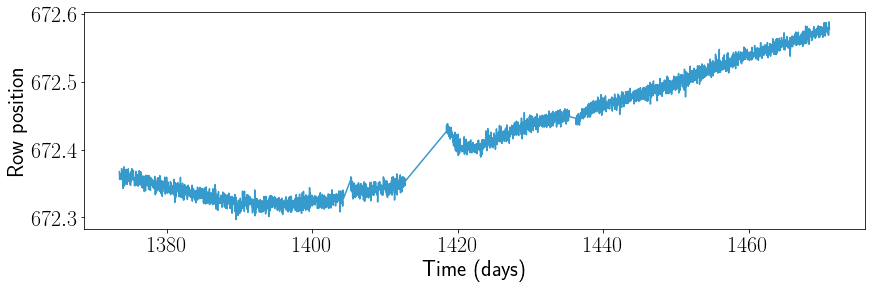

In [39]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, ycenter_gauss, color='#369acd')
plt.ylabel('Row position')
plt.xlabel('Time (days)')

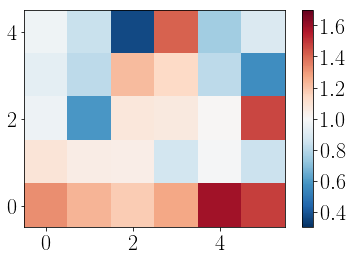

In [40]:
plt.imshow(np.nanmedian(residuals_poisson/residuals_gaussian, axis=0), origin='lower', cmap='RdBu_r',
           vmin=.3, vmax=1.7)
plt.colorbar()

In [41]:
np.nanmean(residuals_poisson[:, 1:3, 3]), np.std(residuals_poisson[:, 1:3, 3])

(9.3530775426409836, 4.448923524173515)

In [42]:
np.nanmean(residuals_gaussian[:, 1:3, 3]), np.std(residuals_gaussian[:, 1:3, 3])

(10.111234963611379, 5.7648748943861738)

In [43]:
np.nanmean(residuals_poisson), np.std(residuals_poisson)

(-2.2513346609389745e-05, 12.578752901737289)

In [44]:
np.nanmean(residuals_gaussian), np.std(residuals_gaussian)

(0.99470203210691654, 12.594192632885269)

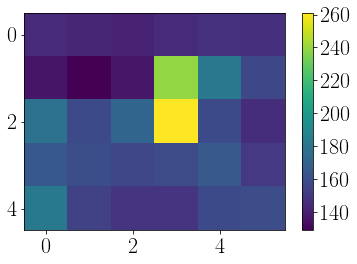

In [45]:
plt.imshow(np.nanmedian(tpf.flux + tpf.flux_bkg, axis=0), cmap='viridis')
plt.colorbar()

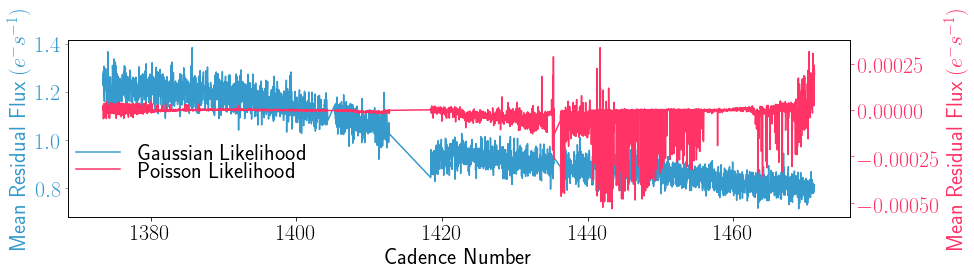

In [46]:
fig, ax1 = plt.subplots(figsize=[14, 4])
ax1.plot(tpf.time, np.nanmean(residuals_gaussian, axis=(1, 2)), color='#369acd', label='Gaussian Likelihood')
ax1.set_xlabel('Cadence Number')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Mean Residual Flux $(e^{-}s^{-1})$', color='#369acd')
ax1.tick_params('y', colors='#369acd')
plt.legend(loc=(0,.25), frameon=False)

ax2 = ax1.twinx()
ax2.plot(tpf.time, np.nanmean(residuals_poisson, axis=(1, 2)), color='#ff3366', label='Poisson Likelihood')
ax2.set_ylabel('Mean Residual Flux $(e^{-}s^{-1})$', color='#ff3366')
ax2.tick_params('y', colors='#ff3366')
plt.legend(loc=(0,.15), frameon=False)
plt.tight_layout()

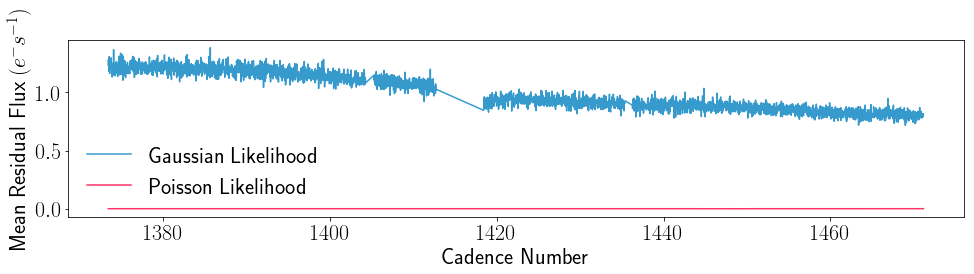

In [50]:
fig, ax1 = plt.subplots(figsize=[14, 4])
ax1.plot(tpf.time, np.nanmean(residuals_gaussian, axis=(1, 2)), color='#369acd', label='Gaussian Likelihood')
ax1.set_xlabel('Cadence Number')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Mean Residual Flux $(e^{-}s^{-1})$')
ax1.plot(tpf.time, np.nanmean(residuals_poisson, axis=(1, 2)), color='#ff3366', label='Poisson Likelihood')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('comparison.eps', transparent=True, bbox_inches='tight', pad_inches=.1)

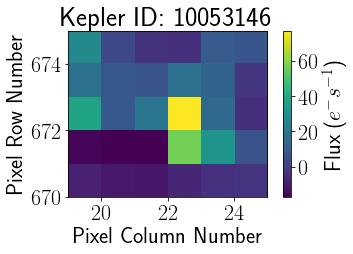

In [44]:
tpf.plot(cadenceno=66662)
plt.tight_layout()